In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from natsort import natsorted
from pathlib import Path

### Loading Data

In [2]:
#load the image and mask images from drive
image_path = []
path_sorted = sorted(os.listdir("/content/drive/MyDrive/data/Images"))
for i in path_sorted:
  path_sorted = os.path.join("/content/drive/MyDrive/data/Images",i)

for root, dirs, files in sorted(os.walk('/content/drive/MyDrive/data/Images')):
    # iterate over 1501 images
    for file in files:
        # create path
        path = os.path.join(root,file)
        # add path to list
        image_path.append(path)
len(image_path)

sorted_image_files = sorted(image_path, key=lambda image_path: Path(image_path).name)


# a list to collect paths of 1501 masks
mask_path = []
for root, dirs, files in os.walk('/content/drive/MyDrive/data/Masks'):
    #iterate over 1501 masks
    for file in files:
        # obtain the path
        path = os.path.join(root,file)
        # add path to the list
        mask_path.append(path)
len(mask_path)
sorted_mask_files = sorted(mask_path, key=lambda mask_path: Path(mask_path).name)



In [3]:
# create a list to store images
images = []
# iterate over 1501 image paths
for path in tqdm(sorted_image_files):
    # read file
    file = tf.io.read_file(path)
    # decode png file into a tensor
    image = tf.image.decode_png(file, channels=3, dtype=tf.uint8)
    # append to the list
    images.append(image)


# create a list to store masks
masks = []
# iterate over 1501 mask paths
for path in tqdm(sorted_mask_files):
    # read the file
    file = tf.io.read_file(path)
    # decode png file into a tensor
    mask = tf.image.decode_png(file, channels=1, dtype=tf.uint8)
    # append mask to the list
    masks.append(mask)

100%|██████████| 1501/1501 [07:57<00:00,  3.15it/s]


### Visualize the image and mask

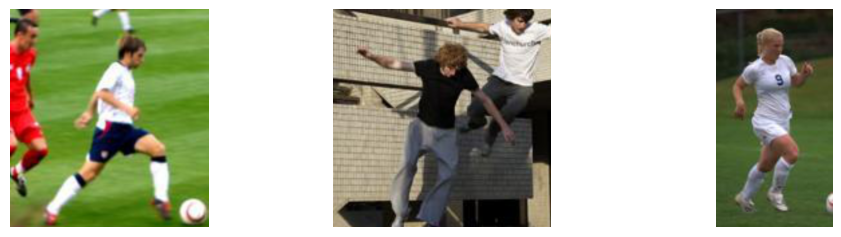

In [4]:
plt.figure(figsize=(25,13))

# plot images
for i in range(4,7):
    # Create a subplot for each image
    plt.subplot(4,6,i)
    # Get the i-th image from the list
    img = images[i]
    # Show the image
    plt.imshow(img)
    # Turn off the axis labels
    plt.axis('off')

# Display the figure
plt.show()

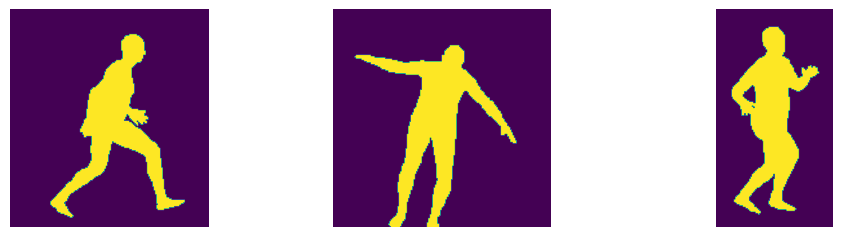

In [5]:


# plot masks
plt.figure(figsize=(25,13))
for i in range(4,7):
    plt.subplot(4,6,i)
    #img = masks[i]
    img = tf.keras.utils.img_to_array(masks[i])
    mask = tf.cast((img>0), tf.float32)
    plt.imshow(mask)
    plt.axis('off')
plt.show()



### Preprocessing

In [6]:
# Resizing the images and mask to 128 x 128

def resize_image(image):
    # scale the image
    image = tf.cast(image, tf.float32)
    image = image/255.0
    # resize image
    image = tf.image.resize(image, (128,128))
    return image

def resize_mask(mask):
    # resize the mask
    mask = tf.image.resize(mask, (128,128))
    mask = tf.cast(mask, tf.uint8)
    return mask


X = [resize_image(i) for i in images]
y = [resize_mask(m) for m in masks]
len(X), len(y)


(1501, 1501)

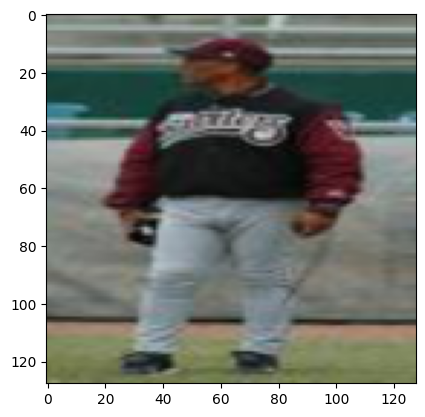

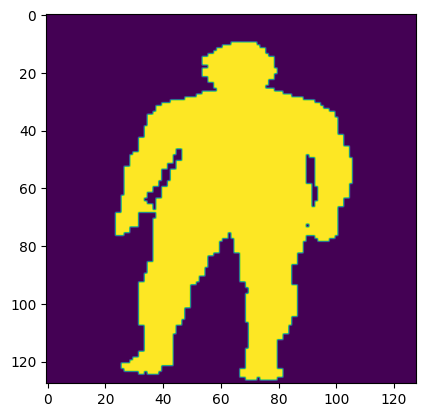

In [7]:
#visualizing a resized image and respective mask
# plot an image
plt.imshow(X[35])
plt.show()

#plot a mask
img = tf.keras.utils.img_to_array(y[35])
mask = tf.cast((img>0), tf.float32)
plt.imshow(mask)
plt.show()

### Model Development

In [8]:
# split data into 80/20 ratio
train_X, val_X,train_y, val_y = train_test_split(X, y, test_size=0.2,
                                                      random_state=0
                                                     )
# develop tf Dataset objects
train_X = tf.data.Dataset.from_tensor_slices(train_X)
val_X = tf.data.Dataset.from_tensor_slices(val_X)

train_y = tf.data.Dataset.from_tensor_slices(train_y)
val_y = tf.data.Dataset.from_tensor_slices(val_y)

# verify the shapes and data types
train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))

In [9]:
#zip images and masks
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y))

In [10]:
#setting the batch size
BATCH = 64

AT = tf.data.AUTOTUNE
#buffersize
BUFFER = 1000

STEPS_PER_EPOCH = 800//BATCH
VALIDATION_STEPS = 200//BATCH

train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
train = train.prefetch(buffer_size=AT)
val = val.batch(BATCH)

In [11]:
# Use pre-trained DenseNet121 without head
base = keras.applications.DenseNet121(input_shape=[128,128,3],
                                      include_top=False,
                                      weights='imagenet')

29084464/29084464 [==============================] - 0s 0us/step


In [12]:
#final ReLU activation layer for each feature map size, i.e. 4, 8, 16, 32, and 64, required for skip-connections
skip_names = ['conv1/relu', # size 64*64
             'pool2_relu',  # size 32*32
             'pool3_relu',  # size 16*16
             'pool4_relu',  # size 8*8
             'relu'        # size 4*4
             ]

In [13]:
# Building Downstack

#output of these layers
skip_outputs = [base.get_layer(name).output for name in skip_names]
#Building the downstack with the above layers. We use the pre-trained model as such, without any fine-tuning.
downstack = keras.Model(inputs=base.input,
                       outputs=skip_outputs)
# freeze the downstack layers
downstack.trainable = False

In [14]:
# Building Upstack

!pip install -q git+https://github.com/tensorflow/examples.git --quiet


from tensorflow_examples.models.pix2pix import pix2pix

# Four upstack layers for upsampling sizes
# 4->8, 8->16, 16->32, 32->64
upstack = [pix2pix.upsample(512,3),
          pix2pix.upsample(256,3),
          pix2pix.upsample(128,3),
          pix2pix.upsample(64,3)]

  Preparing metadata (setup.py) ... done


In [15]:

# define the input layer
inputs = keras.layers.Input(shape=[128,128,3])

# downsample
down = downstack(inputs)
out = down[-1]

# prepare skip-connections
skips = reversed(down[:-1])
# choose the last layer at first 4 --> 8

# upsample with skip-connections
for up, skip in zip(upstack,skips):
    out = up(out)
    out = keras.layers.Concatenate()([out,skip])

# define the final transpose conv layer
# image 128 by 128 with 59 classes
out = keras.layers.Conv2DTranspose(59, 3,
                                  strides=2,
                                  padding='same',
                                  )(out)
# complete unet model
unet = keras.Model(inputs=inputs, outputs=out)

In [16]:
# compiling the model
def Compile_Model():
    unet.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])
Compile_Model()

In [17]:
# training and fine-tuning
hist_1 = unet.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=20,
               verbose=2)

Epoch 1/20
12/12 - 27s - loss: 3.0630 - accuracy: 0.5826 - val_loss: 3.5930 - val_accuracy: 0.7525 - 27s/epoch - 2s/step
Epoch 2/20
12/12 - 12s - loss: 1.8538 - accuracy: 0.7601 - val_loss: 3.2633 - val_accuracy: 0.7500 - 12s/epoch - 1s/step
Epoch 3/20
12/12 - 4s - loss: 1.4257 - accuracy: 0.7612 - val_loss: 2.9276 - val_accuracy: 0.7571 - 4s/epoch - 314ms/step
Epoch 4/20
12/12 - 4s - loss: 1.2157 - accuracy: 0.7644 - val_loss: 2.1640 - val_accuracy: 0.7631 - 4s/epoch - 327ms/step
Epoch 5/20
12/12 - 4s - loss: 1.0978 - accuracy: 0.7669 - val_loss: 2.0024 - val_accuracy: 0.7667 - 4s/epoch - 297ms/step
Epoch 6/20
12/12 - 4s - loss: 1.0326 - accuracy: 0.7685 - val_loss: 1.7014 - val_accuracy: 0.7670 - 4s/epoch - 299ms/step
Epoch 7/20
12/12 - 4s - loss: 0.9730 - accuracy: 0.7722 - val_loss: 1.4039 - val_accuracy: 0.7641 - 4s/epoch - 293ms/step
Epoch 8/20
12/12 - 4s - loss: 0.9406 - accuracy: 0.7737 - val_loss: 1.2791 - val_accuracy: 0.7693 - 4s/epoch - 296ms/step
Epoch 9/20
12/12 - 4s - lo

### Model Evaluation

2/2 [==============================] - 7s 26ms/step


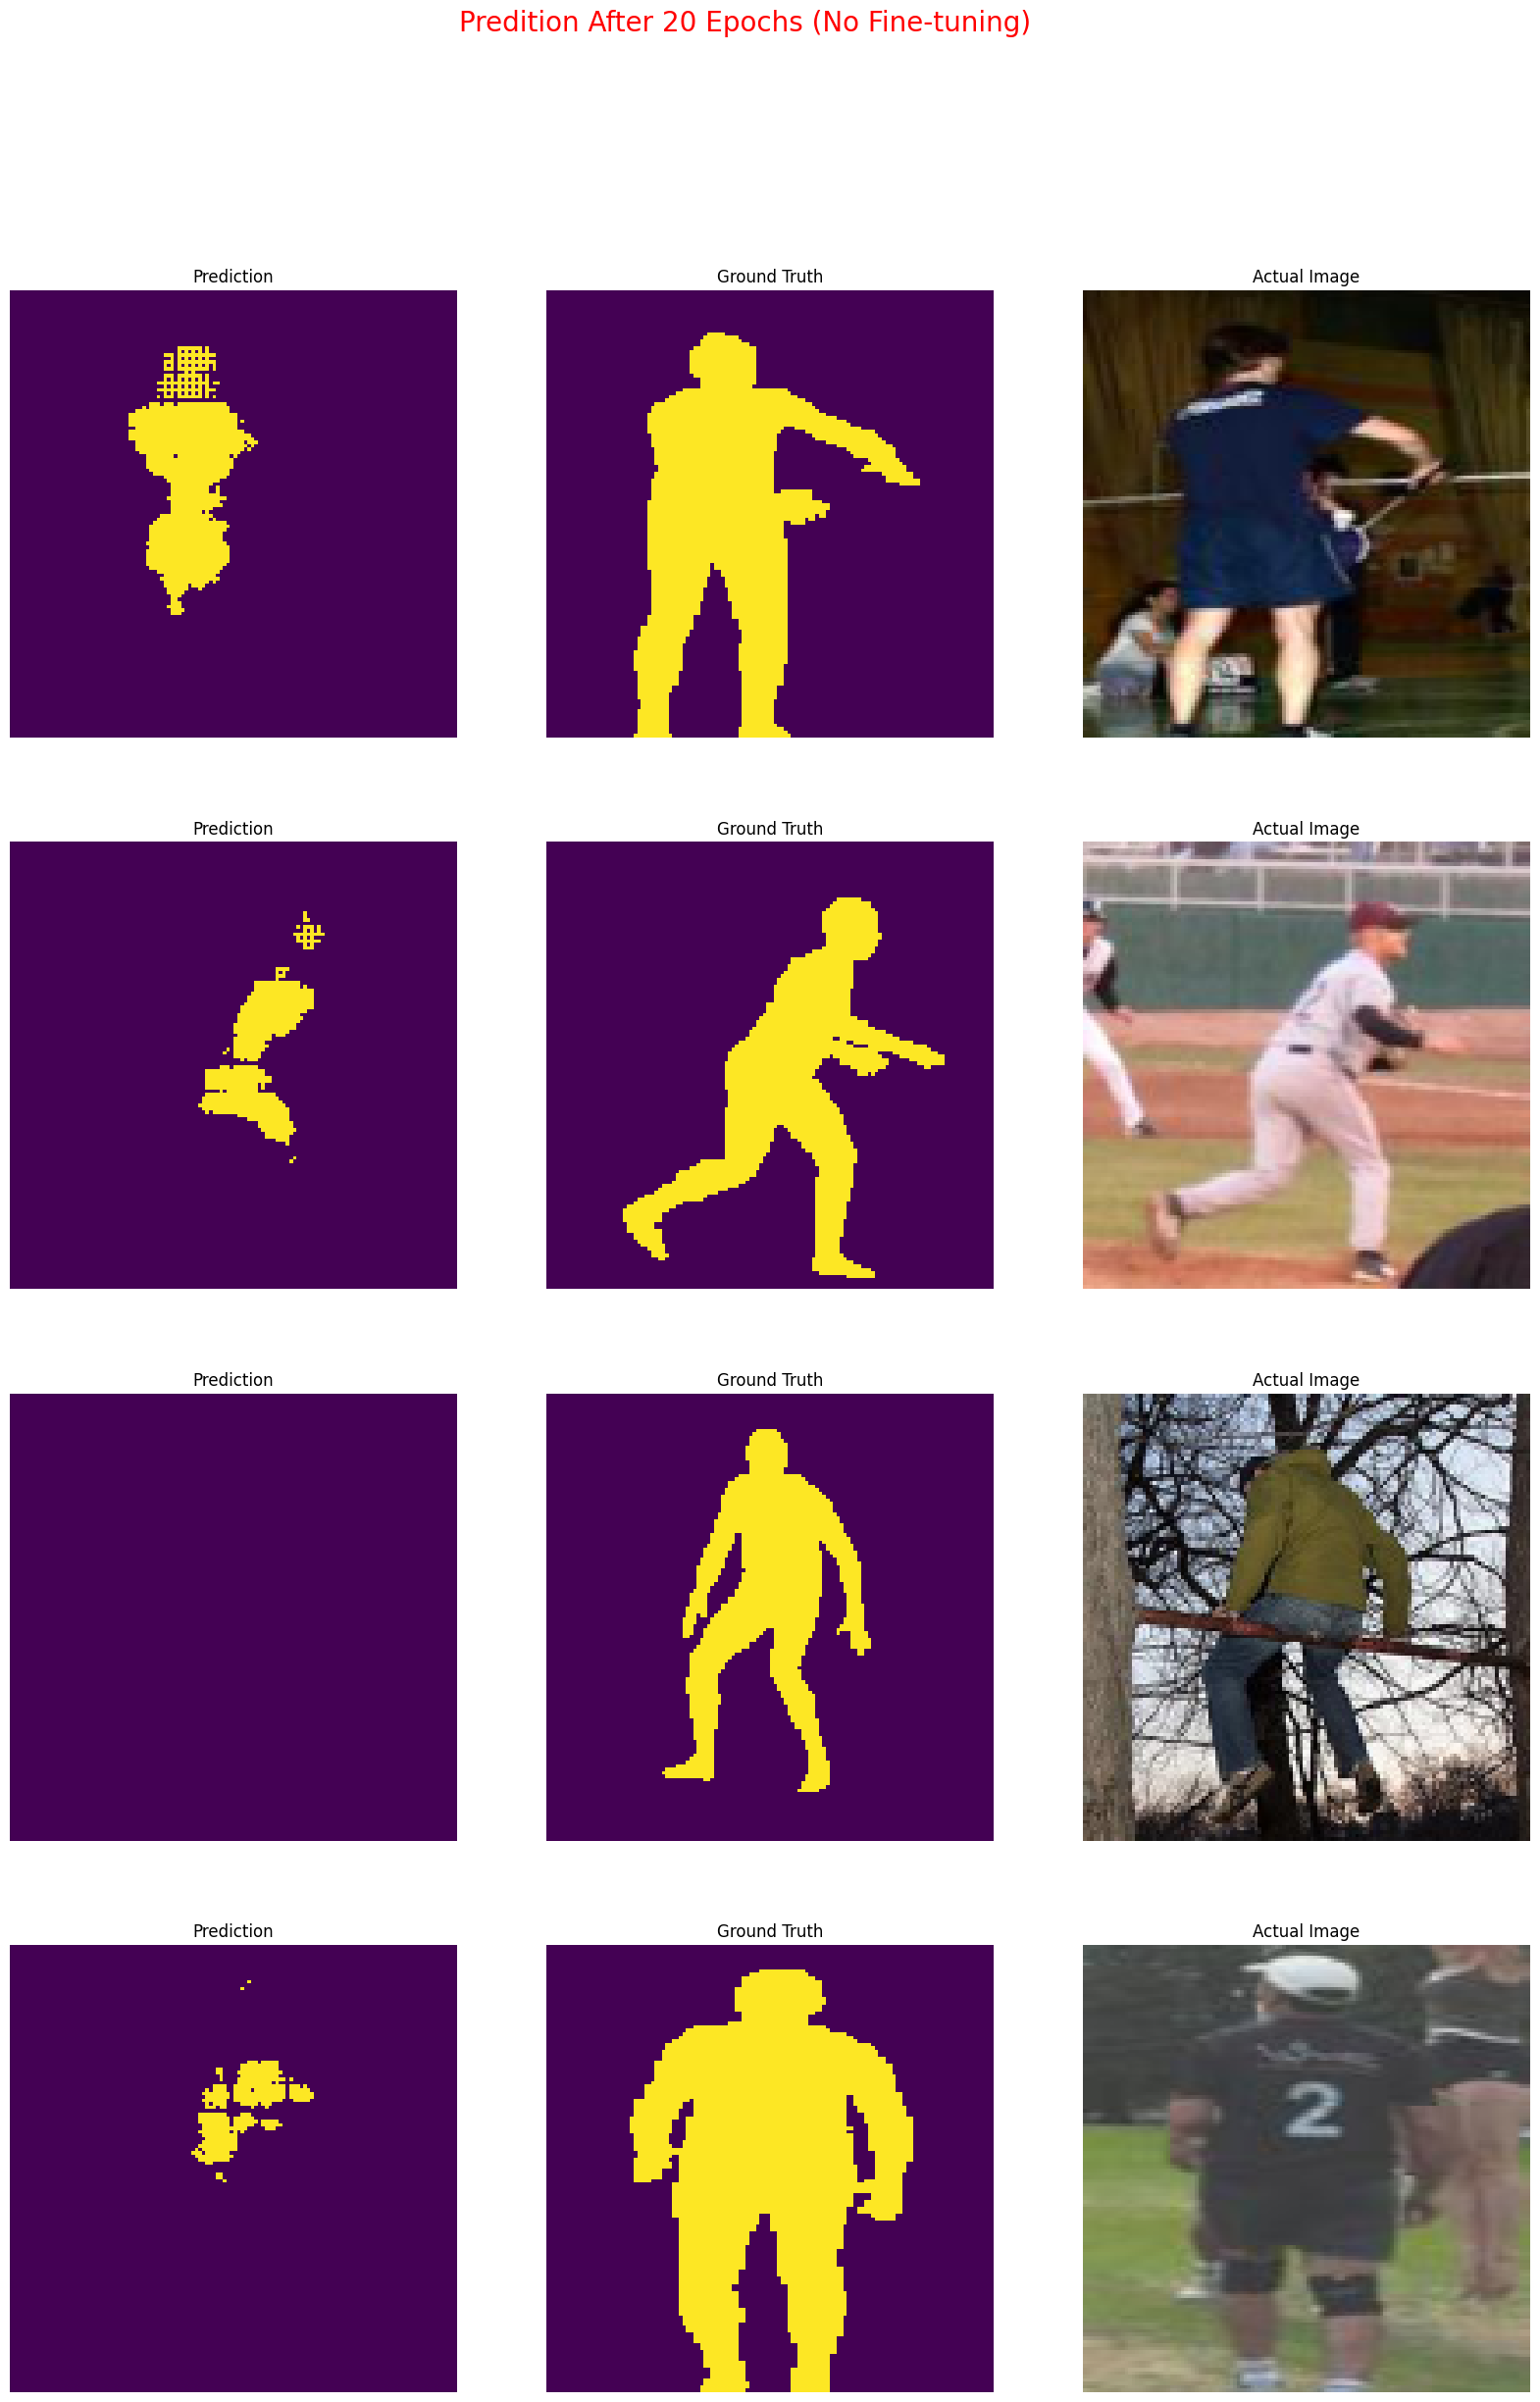

In [18]:
# select a validation data batch
img, mask = next(iter(val))
# make prediction
pred = unet.predict(img)
plt.figure(figsize=(20,28))

k = 0
for i in pred:
    # plot the predicted mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    img1 = tf.keras.utils.img_to_array(i)
    mask1 = tf.cast((img1>0), tf.float32)
    plt.imshow(mask1)
    plt.axis('off')
    plt.title('Prediction')

    # plot the groundtruth mask
    plt.subplot(4,3,2+k*3)
    img2 = tf.keras.utils.img_to_array(mask[k])
    mask2 = tf.cast((img2>0), tf.float32)
    plt.imshow(mask2)
    plt.axis('off')
    plt.title('Ground Truth')

    # plot the actual image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break
plt.suptitle('Predition After 20 Epochs (No Fine-tuning)', color='red', size=20)
plt.show()

In [19]:
downstack.trainable = True
# compile again
Compile_Model()
# train from epoch 20 to 40
hist_2 = unet.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=40, initial_epoch = 20,
               verbose = 2
                 )

Epoch 21/40
12/12 - 58s - loss: 0.7227 - accuracy: 0.7930 - val_loss: 0.7752 - val_accuracy: 0.7906 - 58s/epoch - 5s/step
Epoch 22/40
12/12 - 10s - loss: 0.6261 - accuracy: 0.8072 - val_loss: 0.8146 - val_accuracy: 0.7867 - 10s/epoch - 848ms/step
Epoch 23/40
12/12 - 6s - loss: 0.5982 - accuracy: 0.8112 - val_loss: 0.8133 - val_accuracy: 0.7864 - 6s/epoch - 482ms/step
Epoch 24/40
12/12 - 6s - loss: 0.5751 - accuracy: 0.8168 - val_loss: 0.7331 - val_accuracy: 0.7987 - 6s/epoch - 469ms/step
Epoch 25/40
12/12 - 6s - loss: 0.5566 - accuracy: 0.8213 - val_loss: 0.8120 - val_accuracy: 0.7892 - 6s/epoch - 470ms/step
Epoch 26/40
12/12 - 6s - loss: 0.5228 - accuracy: 0.8320 - val_loss: 0.7795 - val_accuracy: 0.7943 - 6s/epoch - 464ms/step
Epoch 27/40
12/12 - 5s - loss: 0.5179 - accuracy: 0.8343 - val_loss: 0.8140 - val_accuracy: 0.7956 - 5s/epoch - 451ms/step
Epoch 28/40
12/12 - 6s - loss: 0.4949 - accuracy: 0.8449 - val_loss: 0.7326 - val_accuracy: 0.7999 - 6s/epoch - 486ms/step
Epoch 29/40
12/

2/2 [==============================] - 2s 105ms/step


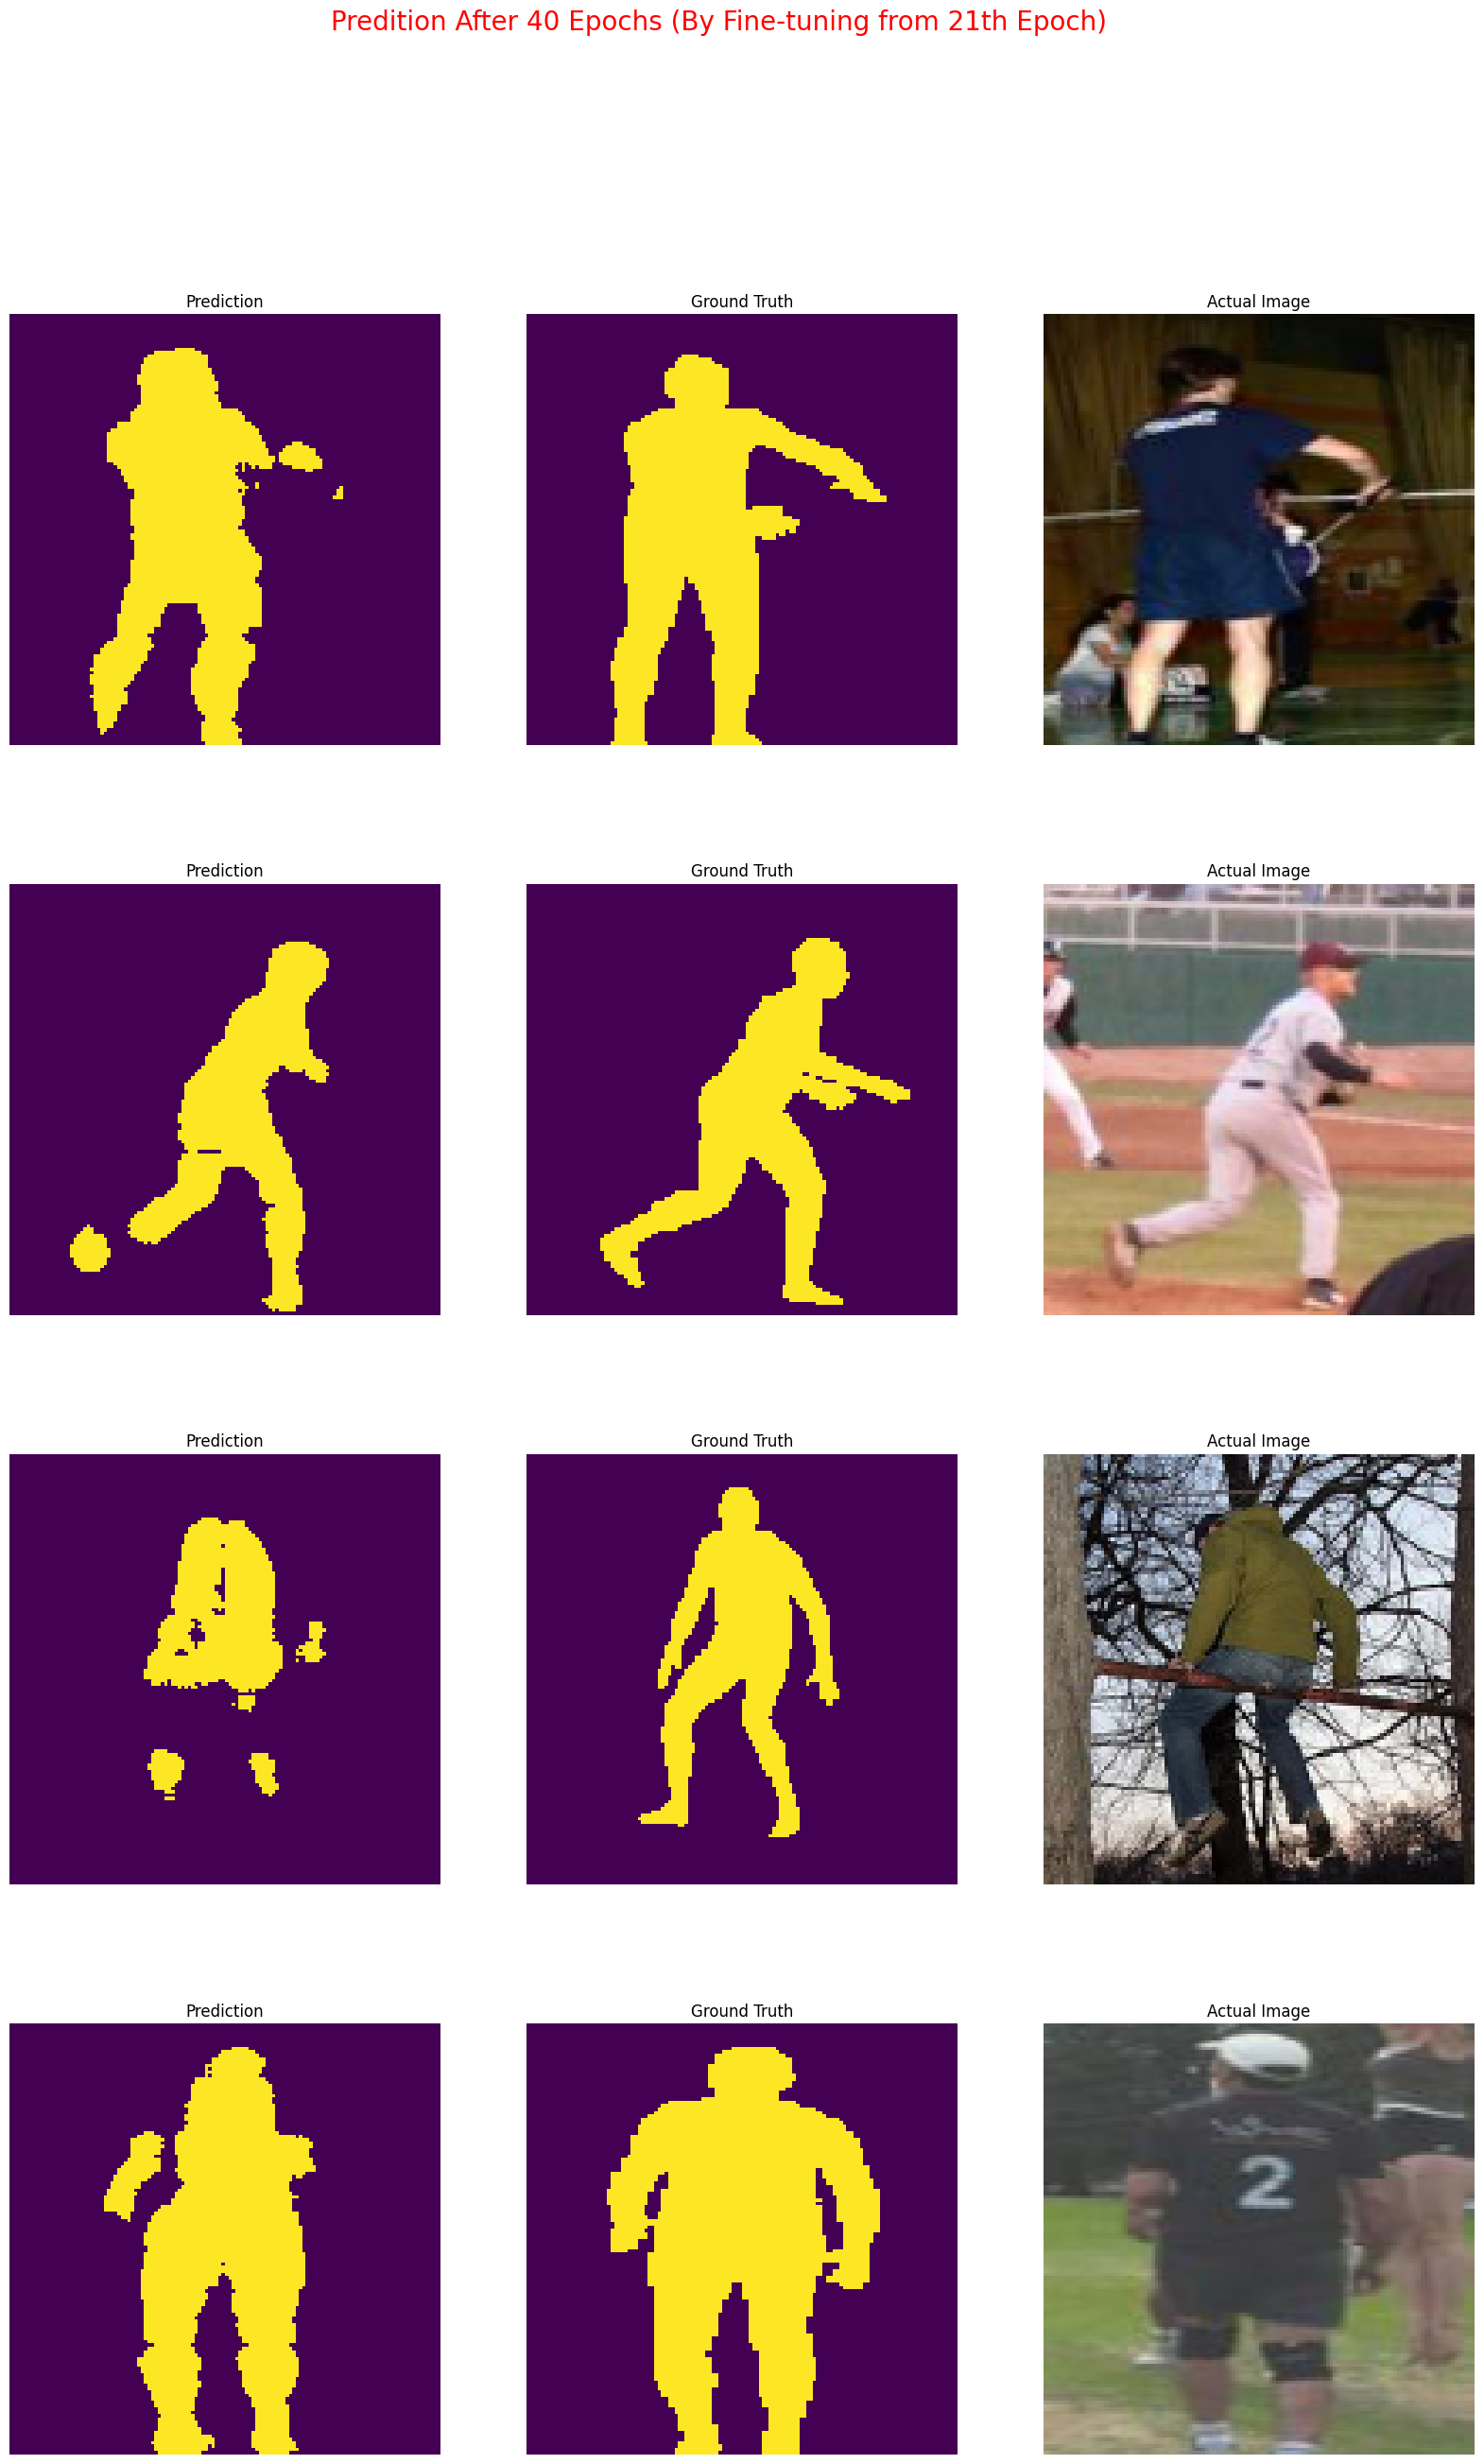

In [20]:
# select a validation data batch
img, mask = next(iter(val))
# make prediction
pred = unet.predict(img)
plt.figure(figsize=(20,30))

k = 0
for i in pred:
    # plot the predicted mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    img1 = tf.keras.utils.img_to_array(i)
    mask1 = tf.cast((img1>0), tf.float32)
    plt.imshow(mask1)
    plt.axis('off')
    plt.title('Prediction')

    # plot the groundtruth mask
    plt.subplot(4,3,2+k*3)
    img2 = tf.keras.utils.img_to_array(mask[k])
    mask2 = tf.cast((img2>0), tf.float32)
    plt.imshow(mask2)
    plt.axis('off')
    plt.title('Ground Truth')

    # plot the actual image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break
plt.suptitle('Predition After 40 Epochs (By Fine-tuning from 21th Epoch)', color='red', size=20)
plt.show()